In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import rmsc05

In [2]:
config = rmsc05.build_config(
    end_time="13:00:00"
)

config.keys()

end_state = abides.run(config)
order_book = end_state["agents"][0].order_books["ABM"]

[3664] INFO abides Simulation Start Time: 2022-11-15 13:35:22.530439
[3664] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[3664] INFO abides_core.kernel --- Simulation time: 2021-02-05 10:24:13, messages processed: 100,000, wallclock elapsed: 9.46s ---
[3664] INFO abides_core.kernel --- Simulation time: 2021-02-05 11:13:58, messages processed: 200,000, wallclock elapsed: 17.41s ---
[3664] INFO abides_core.kernel --- Simulation time: 2021-02-05 12:05:43, messages processed: 300,000, wallclock elapsed: 24.76s ---
[3664] INFO abides_core.kernel --- Simulation time: 2021-02-05 12:55:50, messages processed: 400,000, wallclock elapsed: 31.91s ---
[3664] INFO abides_core.kernel Event Queue elapsed: 0:00:32.491380, messages: 409,357, messages per second: 12598.9
[3664] INFO abides_core.kernel Mean ending value by agent type:
[3664] INFO abides_core.kernel FundamentalTrackingAgent: 0
[3664] INFO abides_core.kernel NoiseAgen

In [3]:
L1 = order_book.get_L1_snapshots()

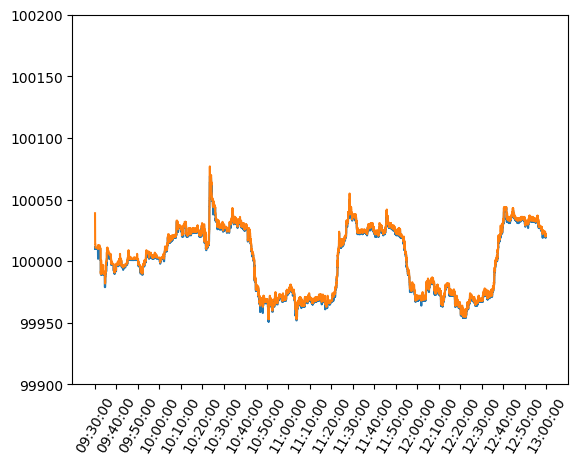

In [4]:
best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])

## All times are in ns from 1970, remove the date component to put them in ns from midnight
best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )

plt.plot(best_bids.time,best_bids.price)
plt.plot(best_asks.time,best_asks.price)

band = 100
plt.ylim(100_000-band,100_100+band)

time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns("13:10:00"),
    1e9*60*10
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [5]:
L2 = order_book.get_L2_snapshots(nlevels=10)

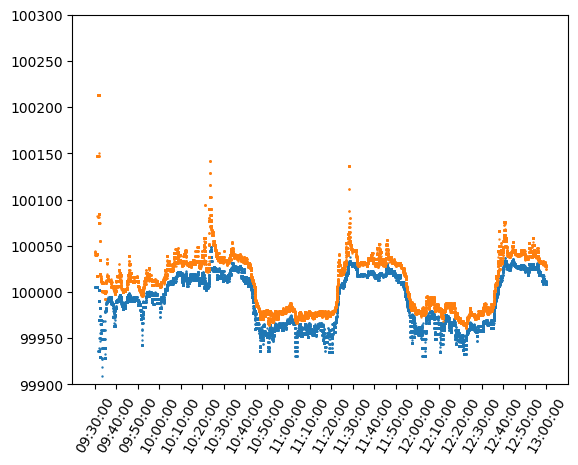

In [6]:
## plotting fifth best bid and fifth best ask
times = [ t - ns_date(t) for t in L2["times"] ]
plt.scatter( times, L2["bids"][:,5,0], s=.5 )
plt.scatter( times, L2["asks"][:,5,0], s=.5 )

band = 100
plt.ylim(100_000-band,100_200+band)

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [7]:
logs_df = parse_logs_df( end_state )

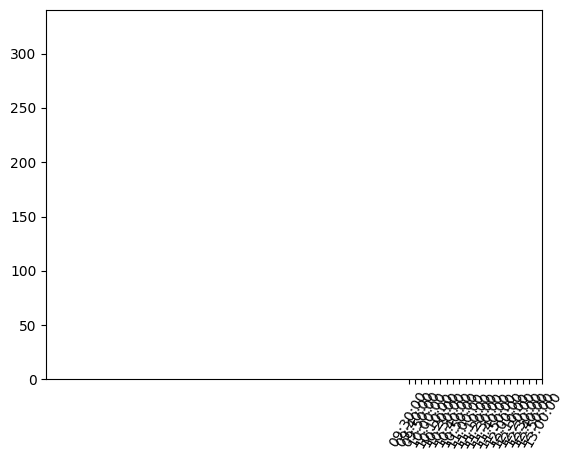

In [8]:
plt.hist( logs_df[ (logs_df.agent_type == "NoiseAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )


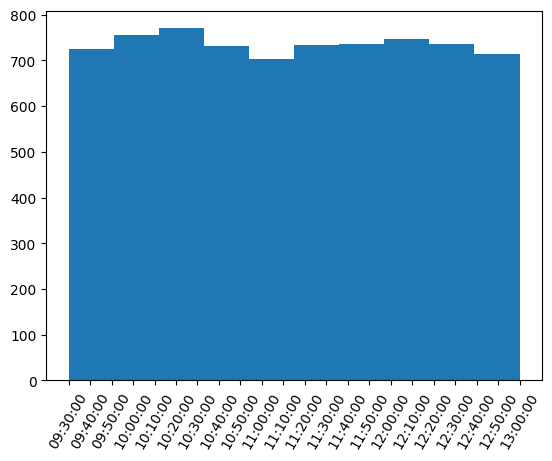

In [9]:
plt.hist( logs_df[ (logs_df.agent_type == "ValueAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

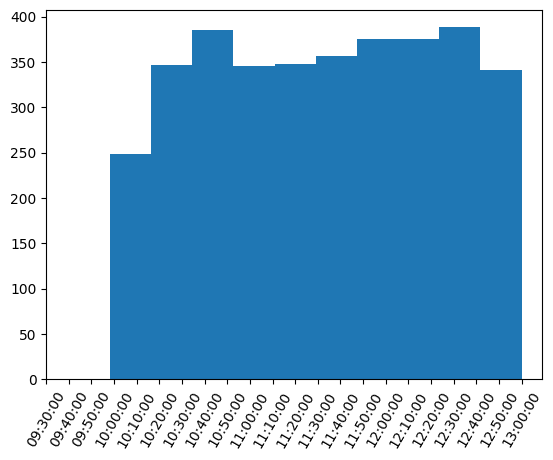

In [10]:
plt.hist( logs_df[ (logs_df.agent_type == "MomentumAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

In [11]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df.to_csv("logs.csv")

In [12]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df_start = df.loc[df['EventType'] == 'STARTING_CASH']
df_start = df_start[['agent_id', 'ScalarEventValue']]
df_end = df.loc[df['EventType'] == 'ENDING_CASH']
df_end = df_end[['agent_id', 'ScalarEventValue']]
df = pd.merge(df_start[['agent_id', 'ScalarEventValue']],
                df_end[['agent_id', 'ScalarEventValue']],
                how='left',
                left_on=['agent_id'],
                right_on=['agent_id'],
                suffixes=['_Open',
                         '_Close'])
df['diff'] = df['ScalarEventValue_Open'] - df['ScalarEventValue_Close']

df


,agent_id,ScalarEventValue_Open,ScalarEventValue_Close,diff
0,1106,10000000,9203536,796464
1,1107,10000000,9198124,801876
2,1108,10000000,9253648,746352
3,1109,10000000,9102267,897733
4,1110,10000000,9206443,793557
5,1111,10000000,9321100,678900
6,1112,10000000,9145046,854954
7,1113,10000000,9229945,770055
8,1114,10000000,9176050,823950
9,1115,10000000,9251021,748979


In [13]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
df = df.loc[df['EventType'] == 'MARKED_TO_MARKET']

df

,EventTime,EventType,ScalarEventValue,agent_id,agent_type,CASH,time_placed,symbol,quantity,side,...,is_price_to_comply,insert_by_id,is_post_only,ABM,current_holdings,current_cash,current_mark_to_market,current_marked_to_market_holdings,performance,spread
161,1612519476445375658,MARKED_TO_MARKET,9999500,1106,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,1612519476445375658,MARKED_TO_MARKET,9999500,1106,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,1612519476445375658,MARKED_TO_MARKET,9999500,1106,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,1612519507501067183,MARKED_TO_MARKET,9999700,1106,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,1612519507501067183,MARKED_TO_MARKET,9999700,1106,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198,1612529915158114038,MARKED_TO_MARKET,9260430,1117,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7208,1612529919593029242,MARKED_TO_MARKET,9260430,1117,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7210,1612529919593029242,MARKED_TO_MARKET,9260430,1117,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7212,1612529919593029242,MARKED_TO_MARKET,9260430,1117,MomentumAgent,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = logs_df[(logs_df.agent_type == "MomentumAgent")]
#df = logs_df.loc[logs_df['EventType'] == 'MARKET_FEE']

total_fee = df['fee'].sum()
print(round(total_fee / 100, 2))

KeyError: 'fee'

In [ ]:
df = logs_df[(logs_df.agent_type == "NoiseAgent")]
#df = df.loc[df['EventType'] == 'ORDER_EXECUTED']

In [ ]:
L2 = order_book.get_L2_snapshots(nlevels=10)

In [ ]:
time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns("13:10:00"),
    1e9*60*10
)

## plotting fifth best bid and fifth best ask
times = [ t - ns_date(t) for t in L2["times"] ]
plt.scatter( times, L2["bids"][:,5,0], s=.5 )
plt.scatter( times, L2["asks"][:,5,0], s=.5 )

band = 100
plt.ylim(100_000-band,100_200+band)

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )